<a href="https://colab.research.google.com/github/eterniacockers/BASH-Risk/blob/main/ATL_Granger_tests_for_features_time_series_relationship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
#Local Runtime
file_path = "C:/Users/jason/Desktop/PhD/Dissertation/Data/ATL/ATL_Data_Python_Imputed.xlsx"
data = np.load(file_path)

In [ ]:
# Preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer

# Load dataset
df = pd.read_excel('C:/Users/jason/Desktop/PhD/Dissertation/Data/ATL/ATL_Data_Python_Imputed.xlsx')

# Convert 'DATE_and_Time' to datetime and sort by date
df['DATE_and_Time'] = pd.to_datetime(df['DATE_and_Time'])
df.sort_values(by='DATE_and_Time', inplace=True)

# Define feature groups
numeric_vars = [
    "Max_Risk", "Altimeter", "Precipitation", "Humidity", "Visibility",
    "Wet_Bulb", "Wind_Speed", "10_Day_Precip"
]
categorical_vars = ["Sky_Cond", "Risk"]  # Keep 'Risk' for classification

# Drop unnecessary columns (but keep Max_Risk and Risk)
df = df.drop(columns=["Station", "4_hr_Precip", "4_hr_Sky_Cond"])

# One-hot encode categorical variables (Sky_Cond)
df = pd.get_dummies(df, columns=['Sky_Cond'], drop_first=False)

# **Apply Sin-Cos Transformation for Wind_Direction**
df["Wind_Direction_Sin"] = np.sin(np.radians(df["Wind_Direction"]))
df["Wind_Direction_Cos"] = np.cos(np.radians(df["Wind_Direction"]))
df.drop(columns=["Wind_Direction"], inplace=True)  # Drop original Wind_Direction column

# Create time-lagged features (for DBN)
time_lags = [4, 8, 12, 24]  # Define relevant lags
for lag in time_lags:
    df[f"Max_Risk_Lag_{lag}"] = df["Max_Risk"].shift(lag)

# **Drop rows with NaN in lagged features**
df = df.dropna().reset_index(drop=True)

# **Discretize numerical features for DBN**
n_bins = 10
kbins = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
df[numeric_vars] = kbins.fit_transform(df[numeric_vars]).astype(int)  # Convert to int for DBN

# **Drop NaNs after discretization**
df = df.dropna().reset_index(drop=True)

# Save the cleaned dataset
df.to_csv('C:/Users/jason/Desktop/PhD/Dissertation/Data/ATL/cleaned_data_max_risk_sin_cos.csv', index=False)

print("✅ Preprocessing complete. Updated dataset saved with Sin-Cos Wind Direction and discretized features.")


✅ Preprocessing complete. Updated dataset saved with Sin-Cos Wind Direction and discretized features.


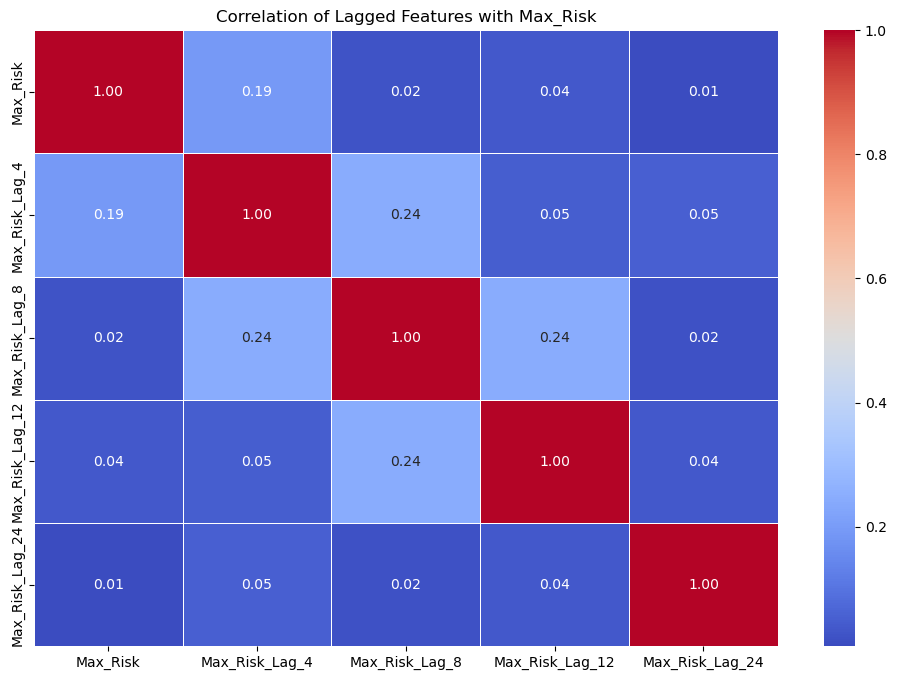

In [ ]:
#Correlation analysis
import seaborn as sns
import matplotlib.pyplot as plt

# Select columns for correlation analysis
lagged_features = [col for col in df.columns if "Lag" in col]
correlation_matrix = df[["Max_Risk"] + lagged_features].corr()

# Plot heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation of Lagged Features with Max_Risk")
plt.show()


In [ ]:
# Generate lagged features for external variables
lags_to_test = [4, 8, 24]
external_features = ["Wind_Speed", "Wet_Bulb", "Humidity"]

for feature in external_features:
    for lag in lags_to_test:
        df[f"{feature}_Lag_{lag}"] = df[feature].shift(lag)

# Drop NaNs created by shifting
df.dropna(inplace=True)
print("✅ Lagged features created and NaN rows removed.")


✅ Lagged features created and NaN rows removed.


In [ ]:
#Granger Tests
from statsmodels.tsa.stattools import grangercausalitytests

# Define lags for Granger Causality
lags_to_test = [4, 8, 24]  # Based on AutoReg results
external_features = ["Wind_Speed", "Wet_Bulb", "Humidity"]

# Run Granger Causality Test for each feature
for feature in external_features:
    for lag in lags_to_test:
        lagged_feature = f"{feature}_Lag_{lag}"
        if lagged_feature in df.columns:  # Ensure the feature exists
            print(f"\n📌 Granger Causality Test for {feature} (Lag {lag}) Predicting Max_Risk")
            grangercausalitytests(df[["Max_Risk", lagged_feature]], maxlag=lag)  # Fixed keyword




📌 Granger Causality Test for Wind_Speed (Lag 4) Predicting Max_Risk

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.6558 , p=0.0000  , df_denom=43680, df_num=1
ssr based chi2 test:   chi2=18.6570 , p=0.0000  , df=1
likelihood ratio test: chi2=18.6531 , p=0.0000  , df=1
parameter F test:         F=18.6558 , p=0.0000  , df_denom=43680, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.3696 , p=0.0000  , df_denom=43677, df_num=2
ssr based chi2 test:   chi2=20.7416 , p=0.0000  , df=2
likelihood ratio test: chi2=20.7367 , p=0.0000  , df=2
parameter F test:         F=10.3696 , p=0.0000  , df_denom=43677, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2864  , p=0.0000  , df_denom=43674, df_num=3
ssr based chi2 test:   chi2=27.8638 , p=0.0000  , df=3
likelihood ratio test: chi2=27.8549 , p=0.0000  , df=3
parameter F test:         F=9.2864  , p=0.0000  , df_denom=43674, df_num=3

Granger Caus

In [ ]:
# Check if lagged features exist in df
for feature in ["Wind_Speed", "Wet_Bulb", "Humidity"]:
    for lag in [4, 8, 24]:
        lagged_feature = f"{feature}_Lag_{lag}"
        if lagged_feature in df.columns:
            print(f"✅ Found: {lagged_feature}")
        else:
            print(f"❌ Missing: {lagged_feature}")


✅ Found: Wind_Speed_Lag_4
✅ Found: Wind_Speed_Lag_8
✅ Found: Wind_Speed_Lag_24
✅ Found: Wet_Bulb_Lag_4
✅ Found: Wet_Bulb_Lag_8
✅ Found: Wet_Bulb_Lag_24
✅ Found: Humidity_Lag_4
✅ Found: Humidity_Lag_8
✅ Found: Humidity_Lag_24


In [ ]:
from statsmodels.tsa.ar_model import AutoReg

# Train an autoregressive model using lagged features
lags = [4, 8, 12, 24]  # Test multiple time lags
selected_lags = [col for col in df.columns if any(f"Lag_{lag}" in col for lag in lags)]

# Fit autoregressive model
model = AutoReg(df["Max_Risk"], lags=[4, 8, 12, 24]).fit()
print(model.summary())


                            AutoReg Model Results                             
Dep. Variable:               Max_Risk   No. Observations:                43684
Model:             Restr. AutoReg(24)   Log Likelihood               25612.553
Method:               Conditional MLE   S.D. of innovations              0.135
Date:                Fri, 09 May 2025   AIC                         -51213.107
Time:                        11:17:29   BIC                         -51161.002
Sample:                            24   HQIC                        -51196.682
                                43684                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0032      0.001      4.991      0.000       0.002       0.004
Max_Risk.L4      0.2027      0.005     42.376      0.000       0.193       0.212
Max_Risk.L8     -0.0322      0.005     -6.59

C:\Users\jason\anaconda3\envs\tf_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [ ]:
#ADF Tests
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Max_Risk'])
print(f"ADF Statistic: {result[0]}, p-value: {result[1]}")


ADF Statistic: -46.40715062255207, p-value: 0.0


In [ ]:
#Check if stationary
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# ✅ List of continuous features you want to check
continuous_features = [
    'Max_Risk', 'Wind_Speed', 'Wet_Bulb', 'Humidity',
    'Altimeter', 'Precipitation', 'Visibility', '10_Day_Precip'
]

# ✅ Store results
stationarity_results = []

# ✅ Loop through each feature and run ADF test
for col in continuous_features:
    series = df[col].dropna()
    adf_result = adfuller(series)
    stat = adf_result[0]
    pval = adf_result[1]
    conclusion = 'Stationary ✅' if pval < 0.05 else 'Non-Stationary ❌'
    stationarity_results.append({
        'Feature': col,
        'ADF Statistic': stat,
        'p-value': pval,
        'Conclusion': conclusion
    })

# ✅ Output as DataFrame
stationarity_df = pd.DataFrame(stationarity_results)
print(stationarity_df)


         Feature  ADF Statistic       p-value    Conclusion
0       Max_Risk     -46.407151  0.000000e+00  Stationary ✅
1     Wind_Speed     -23.472069  0.000000e+00  Stationary ✅
2       Wet_Bulb      -9.090832  3.828389e-15  Stationary ✅
3       Humidity     -22.123150  0.000000e+00  Stationary ✅
4      Altimeter     -19.865864  0.000000e+00  Stationary ✅
5  Precipitation     -80.570861  0.000000e+00  Stationary ✅
6     Visibility     -22.070281  0.000000e+00  Stationary ✅
7  10_Day_Precip     -15.334908  3.900716e-28  Stationary ✅


In [ ]:
for row in stationarity_results:
    if row['p-value'] > 0.05:
        feature = row['Feature']
        df[f"{feature}_diff"] = df[feature].diff()


In [ ]:
#ADF Tests for each feature
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import os

def run_adf_tests_and_save(df, features, airfield_code, save_path):
    """
    Runs ADF tests on the selected features, saves the results as a CSV.

    Parameters:
    - df: pandas DataFrame with your data
    - features: list of column names to test
    - airfield_code: short code to label the file (e.g., 'ATL')
    - save_path: folder to save the CSV (must end with / or \\)
    """
    # ✅ Ensure directory exists
    os.makedirs(save_path, exist_ok=True)

    # ✅ Collect test results
    stationarity_results = []
    for col in features:
        series = df[col].dropna()
        result = adfuller(series)
        stat = result[0]
        pval = result[1]
        conclusion = 'Stationary ✅' if pval < 0.05 else 'Non-Stationary ❌'
        stationarity_results.append({
            'Feature': col,
            'ADF Statistic': stat,
            'p-value': pval,
            'Conclusion': conclusion
        })

    # ✅ Convert to DataFrame and save
    stationarity_df = pd.DataFrame(stationarity_results)
    filename = f"{save_path}{airfield_code}_ADF_Stationarity_Results.csv"
    stationarity_df.to_csv(filename, index=False)
    print(f"✅ ADF results saved to: {filename}")

    return stationarity_df

continuous_features = [
    'Max_Risk', 'Wind_Speed', 'Wet_Bulb', 'Humidity',
    'Altimeter', 'Precipitation', 'Visibility', '10_Day_Precip'
]

save_path = "C:/Users/jason/Desktop/PhD/Dissertation/Data/ATL/"
run_adf_tests_and_save(df, continuous_features, airfield_code="ATL", save_path=save_path)


✅ ADF results saved to: C:/Users/jason/Desktop/PhD/Dissertation/Data/ATL/ATL_ADF_Stationarity_Results.csv


,Feature,ADF Statistic,p-value,Conclusion
0,Max_Risk,-46.407151,0.000000e+00,Stationary ✅
1,Wind_Speed,-23.472069,0.000000e+00,Stationary ✅
2,Wet_Bulb,-9.090832,3.828389e-15,Stationary ✅
3,Humidity,-22.123150,0.000000e+00,Stationary ✅
4,Altimeter,-19.865864,0.000000e+00,Stationary ✅
5,Precipitation,-80.570861,0.000000e+00,Stationary ✅
6,Visibility,-22.070281,0.000000e+00,Stationary ✅
7,10_Day_Precip,-15.334908,3.900716e-28,Stationary ✅
